In [1]:
import os
from pathlib import Path
import options_wizard as ow
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir(): 
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

start_date = ow.DateObj(2008, 1, 1)
end_date = ow.DateObj(2020, 12, 31)
save_type = ow.SaveType.PICKLE
stock = 'NDQ'
universe = ow.Universe([stock])


In [2]:
delta_tol = 0.02

atm_spec = ow.OptionsTradeSpec(
    call_put=ow.OptionType.PUT,
    ttm=lambda t: (t >= 60) and (t <= 150),
    lm_fn=lambda k: True,
    abs_delta=lambda d: (abs(d) >= 0.45 - delta_tol) and (abs(d) <= 0.45 + delta_tol),
    entry_min="perc_spread",
    max_hold_period=30,
    position = -1.0
)


# --- OTM leg spec ---
otm_spec = ow.OptionsTradeSpec(
    call_put=ow.OptionType.PUT,
    ttm=lambda t: (t >= 60) and (t <= 150),
    lm_fn=lambda k: True,
    abs_delta=lambda d: (abs(d) <= 0.075 + delta_tol) and (abs(d) >= 0.075 - delta_tol),
    entry_min="perc_spread",
    max_hold_period=30,
    position = 3.0
)

specs = [atm_spec, otm_spec]

In [3]:
from functools import partial
from operator import le, eq

suffix = "45_10_1x3"


pipeline = ow.Pipeline(universe=universe, save_type=save_type, saves = [ow.SaveFrames.STRAT])
kwargs = {
    'max_date': end_date.to_pl(),
    'keep_col' : ['call_put', 'ttm', 'n_missing'],
    'keep_oper': [eq, le, le],
    'keep_val': ['p', 150, 0],
    'specs': specs,
    'hold_period': 30,
    'protected_notional': 1_000_000,
    'suffix': suffix
    }

ow.wrap_fn = partial(ow.wrap_fn, pipeline=pipeline, kwargs=kwargs)
ow.add_idx_spread_methods(pipeline, kwargs)


In [4]:
pipeline.run()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:55<00:00, 56.00s/it, failed=0]


In [4]:
import options_wizard as ow
from functools import partial

start_cash = 1_000_000


ptf = partial(
    ow.Trade,
    transaction_cost_model=ow.TransactionCostModel.SPREAD,
    accounting_type=ow.AccountingConvention.MTM
)
cfg = ow.BackTestConfig(
    starting_cash = start_cash,
    start_date=start_date,
    end_date=end_date,
    kwargs=kwargs
)
position = ow.FixedHoldNotional(cfg)

spread_capture_override = 0.5
strat = ow.StratType.load(stock, save_type=save_type, suffix=suffix)  
trades = strat.reconstruct(ptf)
for trade in trades:
    trade._spread_capture = spread_capture_override
position.add_trade(trades)

In [5]:
result = ow.BackTestCoordinator(
    position = position,
    dates = ow.market_dates(start_date, end_date, exchange=ow.Exchange.NASDAQ),
    debug = True
).run()

100%|██████████| 3274/3274 [00:06<00:00, 488.15it/s]


C:\Users\cameronA\AppData\Local\Temp\ipykernel_44656\2949128887.py:60: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


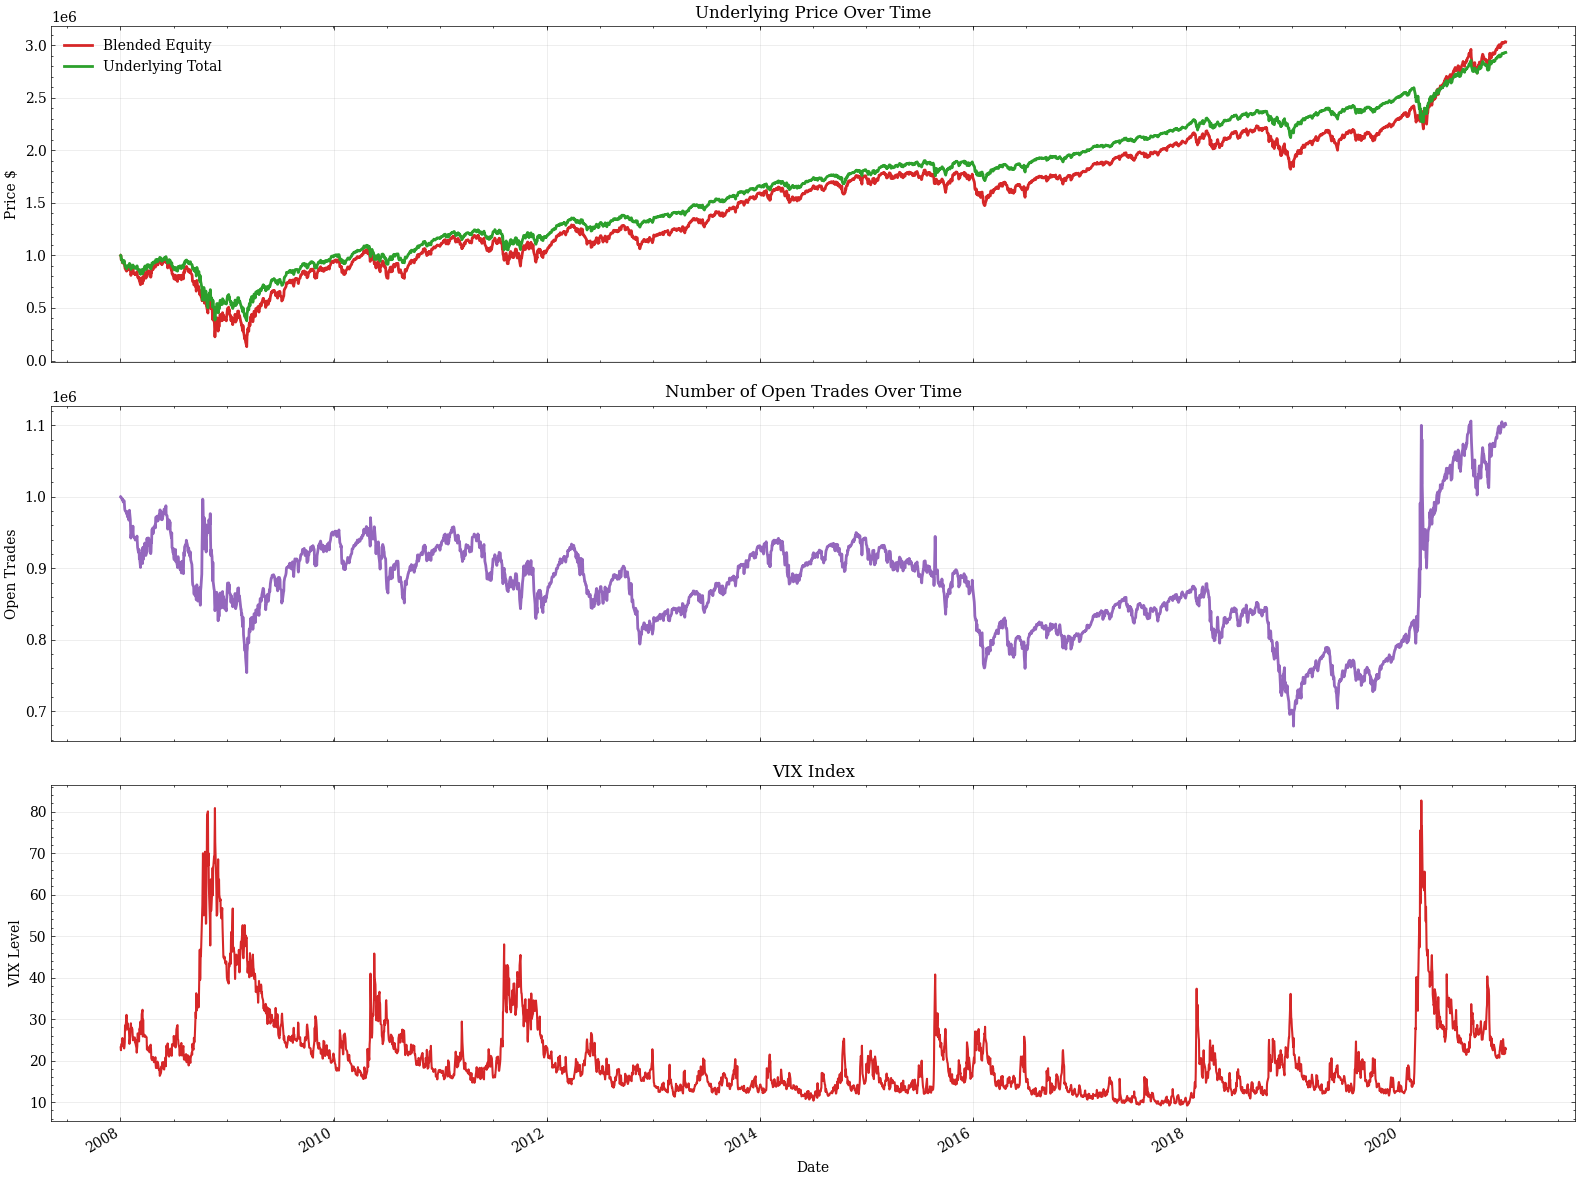

In [8]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotx
import scienceplots
import pandas as pd
import matplotlib

matplotlib.style.use('science')
matplotlib.rcParams['text.usetex'] = False


# ---------------------------
# Existing data
# ---------------------------

equity = np.array([snap.total_equity + snap.total_cash for snap in result.snapshots])
n_trades = np.array([len([key for key in snap.trade_equities.keys()]) for snap in result.snapshots])
dates = np.array([snap.date.to_datetime() for snap in result.snapshots])


# ---------------------------
# Index Data
# ---------------------------

idx_data = yf.Ticker('^IXIC').history(start=dates.min(), end=dates.max())
cap = 1_000_000
underlying = idx_data["Close"].to_numpy()/ idx_data["Close"].to_numpy()[0] * cap
underlying = np.asarray(underlying, dtype=float)
u = np.asarray(underlying, dtype=float)
r = np.ones_like(u)


# ---------------------------
# Calculate total with cap investment and accumulated cash
# ---------------------------
r[1:] = u[1:] / u[:-1]
total = np.empty_like(u)
total[0] = cap
total[1:] = cap + np.cumsum(cap * (r[1:] - 1))
underlying_dates = idx_data.index

start_date = dates.min()
end_date = dates.max()

# ---------------------------
# Scaling protection
# ---------------------------
leverage =2
equity_returns = np.ones_like(equity)
equity_returns[1:] = equity[1:] - equity[:-1]
xn_returns = equity_returns * leverage
equity_scaled = np.empty_like(equity)
equity_scaled[0] = cap
equity_scaled[1:] = cap + np.cumsum(xn_returns[1:])

# ---------------------------
# Fetch VIX data
# ---------------------------
vix = yf.download("^VIX", start=start_date, end=end_date)
vix_dates = vix.index.to_pydatetime()
vix_close = vix["Close"].to_numpy()

dates = dates[:-1]
equity = equity[:-1]
n_trades = n_trades[:-1]
equity_scaled = equity_scaled[:-1]

# ---------------------------
# Generating combined portfolio
# ---------------------------

mask_equity = np.isin(underlying_dates, pd.to_datetime(dates).tz_localize('America/New_York'))
mask_underlying = np.isin(pd.to_datetime(dates).tz_localize('America/New_York'), underlying_dates)
masked_equity = equity_scaled[mask_equity]
masked_underlying = total[mask_underlying]

combined_equity = (masked_equity + total - 1_000_000)


# ---------------------------
# Plotting
# ---------------------------
fig, axes = plt.subplots(
    3, 1, figsize=(16, 12), sharex=True,
    gridspec_kw={"height_ratios": [ 1, 1, 1]}
)

# --- Blended ----
axes[0].plot(dates, combined_equity, color="tab:red", lw=2, label="Blended Equity")
axes[0].grid(True, alpha=0.3)

axes[0].plot(underlying_dates, total, color="tab:green", lw=2, label="Underlying Total")
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Underlying Price Over Time")
axes[0].set_ylabel("Price $")
axes[0].legend()

# --- Number of Open Trades ---
axes[1].plot(dates, equity_scaled, color="tab:purple", lw=2, label="Scaled Equity")
axes[1].grid(True, alpha=0.3)
axes[1].set_title("Number of Open Trades Over Time")
axes[1].set_ylabel("Open Trades")

# --- VIX ---
axes[2].plot(vix_dates, vix_close, color="tab:red", lw=1.5)
axes[2].grid(True, alpha=0.3)
axes[2].set_title("VIX Index")
axes[2].set_ylabel("VIX Level")
axes[2].set_xlabel("Date")

# Improve date formatting
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


In [12]:
alphas

{30: 0.06451612903225806,
 100: 0.019801980198019802,
 60: 0.03278688524590164,
 200: 0.009950248756218905}

In [13]:
from dotenv import load_dotenv
from collections import deque
import numpy as np
import polars as pl
import os

load_dotenv()

index_futures_path = os.getenv("NDQ_FUTURES", "").split(os.pathsep)[0]
index_futures_data = pl.read_parquet(index_futures_path)

# --- EMA setup
fast_ema = {}
slow_emas = [60, 200]
for ema in slow_emas:
    fast_ema[ema] = ema // 2

ema_vals = list(fast_ema.values()) + slow_emas

alphas = {ema: 2 / (ema + 1) for ema in ema_vals}
ema_names = {ema: f"ema_{ema}" for ema in ema_vals}

# --- State
emas = deque()
count = 0

lam_vol = 0.999
lam_sharpe = {ema: 0.999 for ema in slow_emas}

ts = 4.5              # k-sigma
H = 45                # effective horizon
sign_eq = {}
best = {}
pos_prev = {s: 0.0 for s in slow_emas}

def update_var(ret, var, lam):
    return lam * var + (1 - lam) * ret * ret

def stopped(pos, k, peak, eq, vol):
    vol_h = vol * np.sqrt(H)
    if pos > 0 and eq < np.exp(-k * vol_h) * peak:
        return True
    if pos < 0 and eq > np.exp(k * vol_h) * peak:
        return True
    return False

# --- Main loop
for row in index_futures_data.iter_rows(named=True):

    ema_row = {}
    ema_row["date"] = row["date"]

    if len(emas) == 0:
        for ema in ema_vals:
            ema_row[ema_names[ema]] = row["close"]

        for slow in slow_emas:
            ema_row[f"var_{slow}"] = 0.0
            ema_row[f"signal_{slow}"] = 0.0
            ema_row[f"sharpe_est_{slow}"] = 0.0
            ema_row[f"stopped_{slow}"] = False
            sign_eq[slow] = 1.0
            best[slow] = 1.0

        ema_row["signal"] = 0.0
        ema_row["return"] = 0.0

    else:
        mkt_retrn = np.log(row["close"] / _close)

        # --- EMA updates
        for ema in ema_vals:
            ema_row[ema_names[ema]] = (
                row["close"] - emas[-1][ema_names[ema]]
            ) * alphas[ema] + emas[-1][ema_names[ema]]

            if ema in fast_ema.values():
                continue

            # --- volatility
            ema_row[f"var_{ema}"] = update_var(
                mkt_retrn,
                emas[-1][f"var_{ema}"],
                lam_vol
            )
            vol = max(np.sqrt(ema_row[f"var_{ema}"]), 1e-8)

            # === HELD POSITION (yesterday)
            pos_held = np.sign(emas[-1][f"signal_{ema}"])

            # update signed equity
            row_update = pos_held * mkt_retrn
            sign_eq[ema] *= np.exp(row_update)

            # reset trailing anchor on HELD regime change
            if pos_held != pos_prev[ema]:
                best[ema] = sign_eq[ema]

            # check stop
            ema_row[f"stopped_{ema}"] = stopped(
                pos_held,
                ts,
                best[ema],
                sign_eq[ema],
                vol
            )

            # update trailing best only if not stopped
            if not ema_row[f"stopped_{ema}"]:
                if pos_held > 0:
                    best[ema] = max(best[ema], sign_eq[ema])
                elif pos_held < 0:
                    best[ema] = min(best[ema], sign_eq[ema])
                else:
                    best[ema] = sign_eq[ema]

            # realised return
            ema_row[f"return_{ema}"] = row_update

            # sharpe estimate
            ema_row[f"sharpe_est_{ema}"] = np.clip(
                ((row_update / vol) * (1 - lam_sharpe[ema])
                 + lam_sharpe[ema] * emas[-1][f"sharpe_est_{ema}"]),
                -3, 3
            )

            # compute NEXT signal
            ema_row[f"signal_{ema}"] = (
                (ema_row[ema_names[fast_ema[ema]]] - ema_row[ema_names[ema]])
                / ema_row[ema_names[fast_ema[ema]]]
                / vol
            )

            # NEXT regime (for next bar)
            pos_next = np.sign(ema_row[f"signal_{ema}"])
            if pos_next != pos_held:
                best[ema] = sign_eq[ema]

            # persist held position
            pos_prev[ema] = pos_held

        # --- ensemble
        signals = np.array([ema_row[f"signal_{s}"] for s in slow_emas])
        weights = np.array([
            ema_row[f"sharpe_est_{s}"] if not ema_row[f"stopped_{s}"] else 0.0
            for s in slow_emas
        ])
        weights = np.clip(weights, 0.0, 1.0)

        if np.any(weights > 0):
            combo_signal = np.dot(weights, signals) / np.sum(weights)
        else:
            combo_signal = 0.0

        ema_row["signal"] = np.sign(np.clip(combo_signal, -1.0, 1.0))
        ema_row["return"] = (
            mkt_retrn * emas[-1]["signal"] if count > 100 else 0.0
        )

    _close = row["close"]
    count += 1
    emas.append(ema_row)

# --- output
ema_df = pl.DataFrame(emas)
index_futures_data = index_futures_data.join(
    ema_df, on="date", how="left"
)


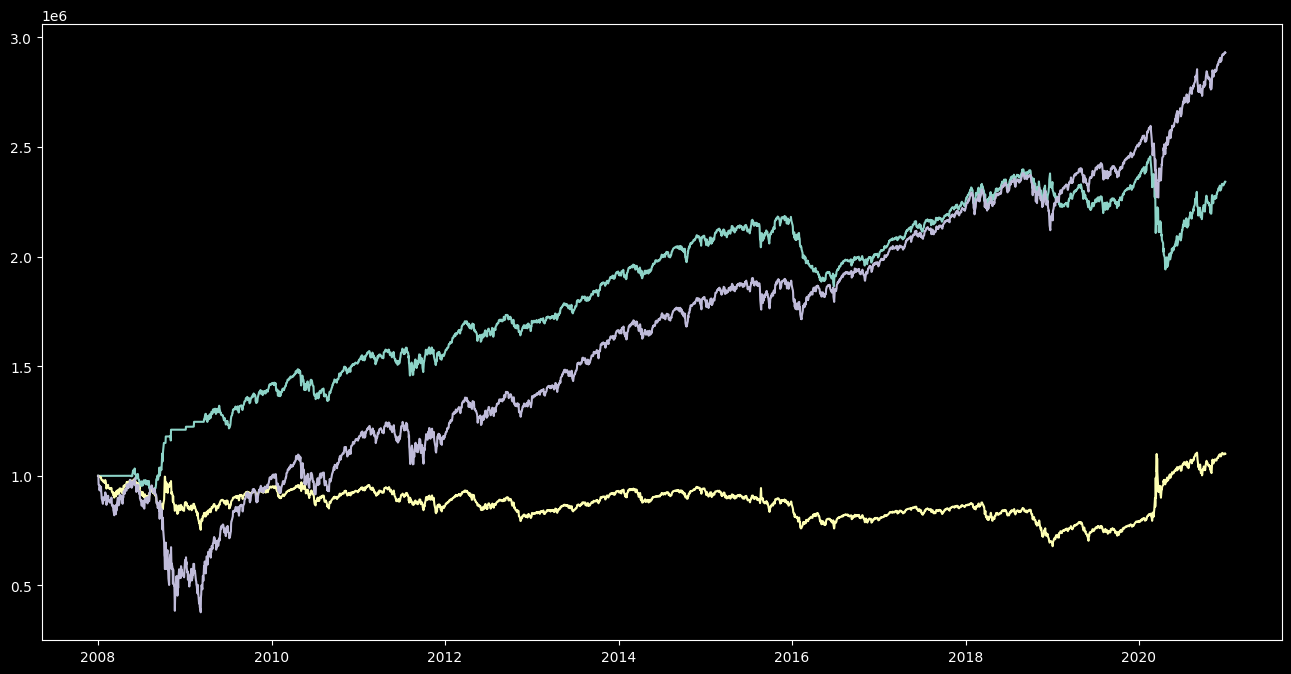

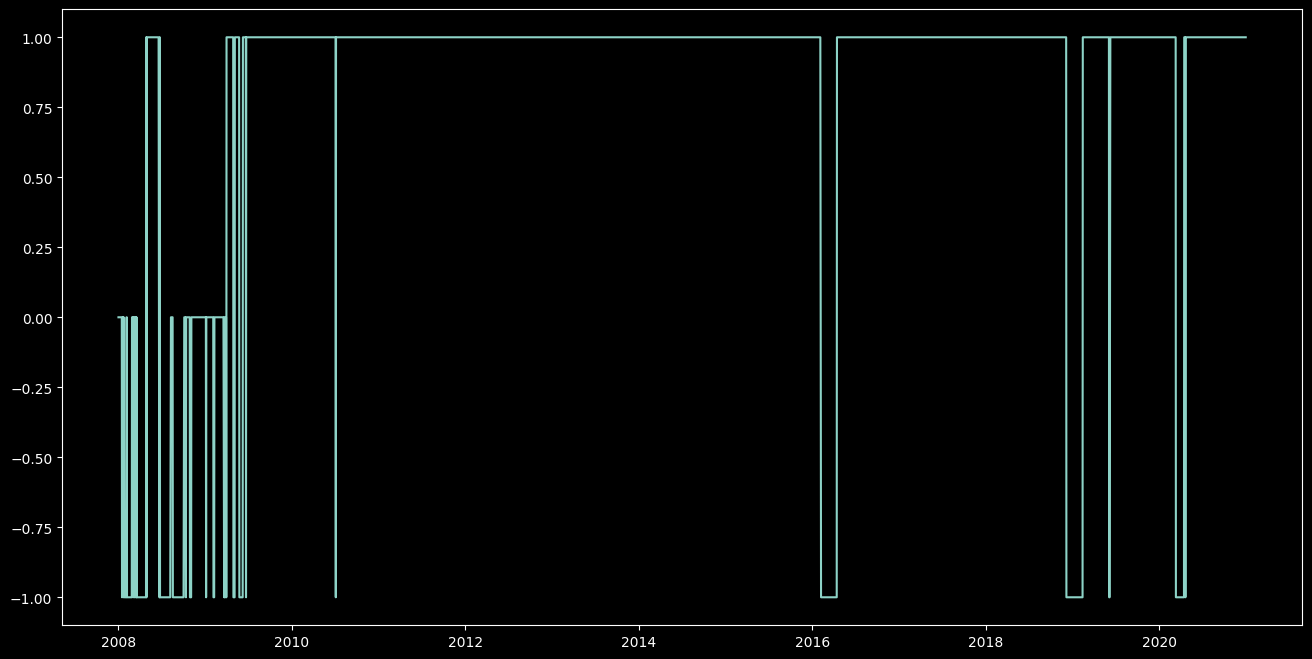

In [14]:
ls =  1_000_000*np.exp(index_futures_data['return'].cum_sum())
ls = ls.filter((start_date <= index_futures_data['date']) & (index_futures_data['date'] <= end_date))
u = np.asarray(ls, dtype=float)
r = np.ones_like(u)
r[1:] = u[1:] / u[:-1]
ls_total = np.empty_like(u)
ls_total[0] = cap
ls_total[1:] = cap + np.cumsum(cap * (r[1:] - 1))
ls_dates = index_futures_data['date'].filter((start_date <= index_futures_data['date']) & (index_futures_data['date'] <= end_date))

start_date = dates.min()
end_date = dates.max()

plt.figure(figsize=(16, 8))
plt.plot(ls_dates, ls_total)

plt.plot(dates, equity_scaled)
plt.plot(underlying_dates, total)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(ls_dates, index_futures_data['signal'].filter((start_date <= index_futures_data['date']) & (index_futures_data['date'] <= end_date)))
plt.show()

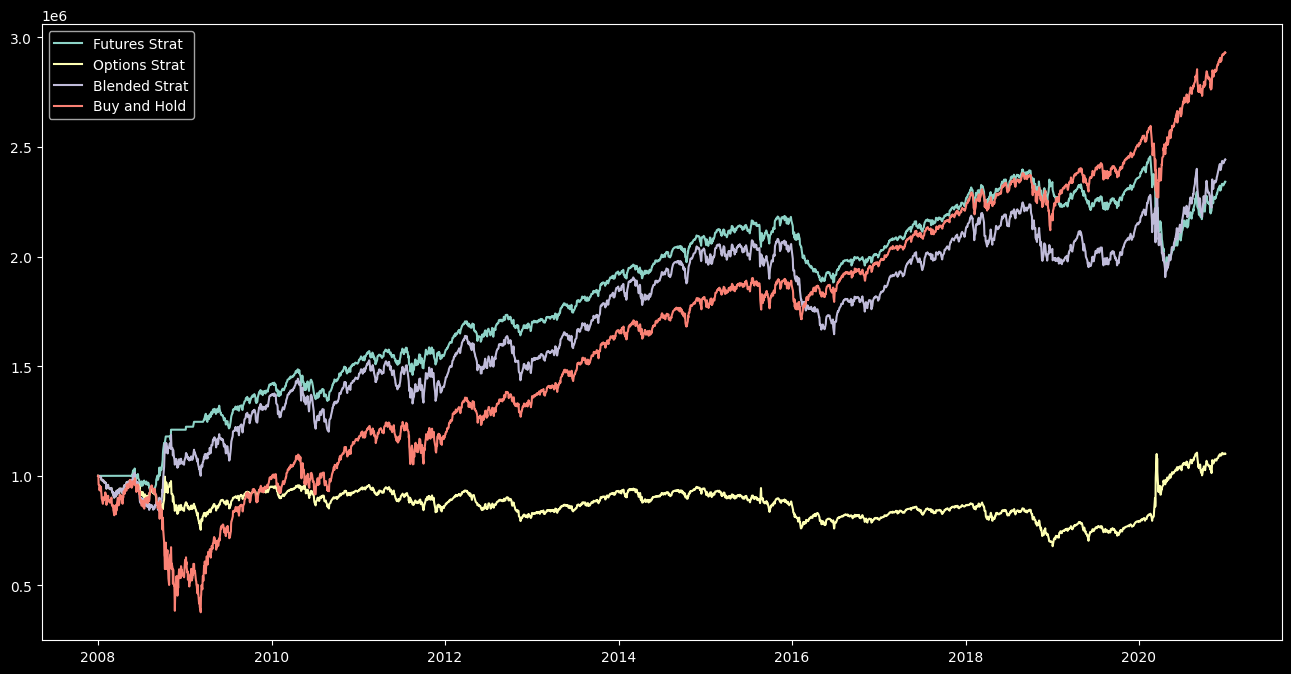

In [15]:
ls_idx = (
    pd.DatetimeIndex(ls_dates.to_pandas())
    .tz_localize("America/New_York")
    .normalize()
)

ud_idx = underlying_dates.normalize()

ud_int = ud_idx.intersection(ls_idx)
ud_dates = ud_int.date

ls_total_int = ls_total[
    ls_dates.is_in(ud_dates)
]
dates_as_date = pd.to_datetime(dates).date
equity_scaled_int = equity_scaled[np.isin(dates_as_date, ud_dates)]

plt.figure(figsize=(16, 8))
plt.plot(ud_dates, ls_total_int, label="Futures Strat")
plt.plot(ud_dates, equity_scaled_int, label="Options Strat")
plt.plot(ud_dates, ls_total_int + equity_scaled_int - 1000000, label="Blended Strat")
plt.plot(ud_idx, total, label="Buy and Hold")
plt.legend()
plt.show()


In [18]:
combined_equity =  ls_total_int + equity_scaled_int - 1000000
combined_returns = (combined_equity[1:] - combined_equity[:-1]) / 1_000_000
combined_sharpe = combined_returns.mean() / combined_returns.std() * np.sqrt(252)
combined_sharpe

np.float64(0.5983333011991812)

In [ ]:
ndq_equity = total
ndq_returns = (ndq_equity[1:] - ndq_equity[:-1] ) / 1_000_000
ndq_sharpe = ndq_returns.mean() / ndq_returns.std() * np.sqrt(252)
ndq_sharpe

np.float64(0.6562824034619874)

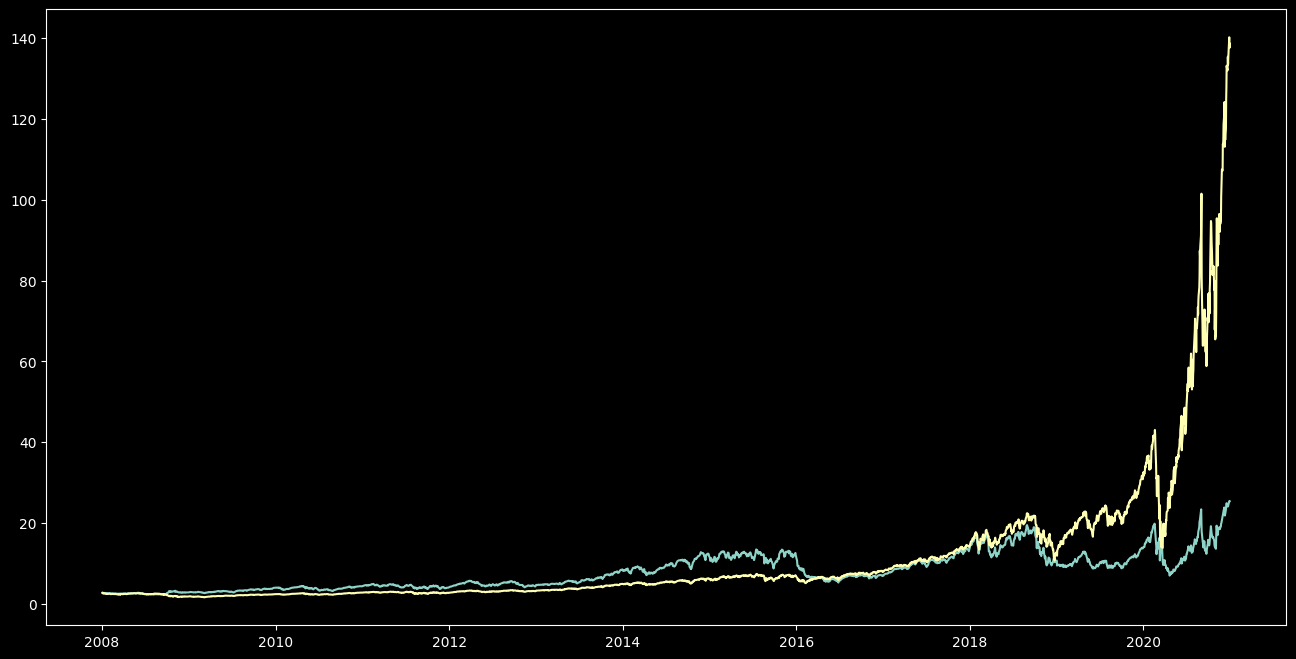

In [42]:
plt.figure(figsize=(16, 8))
plt.plot(ud_dates[1:],np.exp((1+combined_returns).cumprod()))
plt.plot(ud_idx[1:],np.exp((1+ndq_returns).cumprod()))
#plt.plot(ud_idx, ndq_equity)
plt.show()
